In [1]:
from utz import *
import plotly.express as px
import plotly.graph_objects as go
from ire import export, MD

[Papermill](https://papermill.readthedocs.io/) params:

In [2]:
region = None  # ⊆ {NYC,JC,HOB}, comma-delimited

In [3]:
# Parameters
region = "nyc"


In [4]:
all_regions = [ 'NYC', 'JC', 'HOB' ]
regions = region.upper().split(',') if region else all_regions
name_suffix = '' if regions == all_regions else '-'.join([''] + [ r.lower() for r in regions ])

In [5]:
regions_str = "" if regions == all_regions else f" – {', '.join(regions)}"
MD(f"""
# Citi Bike Rides by Month{regions_str}

Subtotals, factored by:
- region (NYC, JC, HOB)
- month/year
- gender (until Feb '21)
- bike ("rideable") type
- number of rides ("Count")
- duration of rides ("Duration")
""", id="rides")


# Citi Bike Rides by Month – NYC

Subtotals, factored by:
- region (NYC, JC, HOB)
- month/year
- gender (until Feb '21)
- bike ("rideable") type
- number of rides ("Count")
- duration of rides ("Duration")


In [6]:
ymrgtb_cd = read_json('../www/public/assets/ymrgtb_cd.json')
ymrgtb_cd['Date'] = ymrgtb_cd[['Year', 'Month']].apply(lambda r: date(r.Year, r.Month, 1), axis=1)
genders = ['Unknown', 'Male', 'Female']
ymrgtb_cd['Gender'] = pd.Categorical(ymrgtb_cd['Gender'].apply(lambda g: genders[g]), categories=genders, ordered=False)
agg = ymrgtb_cd[ymrgtb_cd.Region.isin(regions)]
export(
    agg.drop(columns=['Year', 'Month']).set_index('Date'),
    name=f'ymrgtb_cd{name_suffix}',
    fmts={'Date': '%Y-%m'},
    per_page=20,
)

Saved parquet to .ire/ymrgtb_cd-nyc.parquet


In [7]:
agg.groupby('Rideable Type').Count.sum()

Rideable Type
classic_bike      78905735
docked_bike        8780533
electric_bike     38904399
unknown          112474107
Name: Count, dtype: int64

In [8]:
rides = agg.groupby('Date')['Count'].sum()
rides

Date
2013-06-01     559643
2013-07-01     843416
2013-08-01    1001958
2013-09-01    1034359
2013-10-01    1037712
               ...   
2024-05-01    4219737
2024-06-01    4767035
2024-07-01    4706363
2024-08-01    4586601
2024-09-01    4979708
Name: Count, Length: 136, dtype: int64

In [9]:
agg_12mo = round(rides.rolling(12).mean()).dropna()
agg_12mo

Date
2014-05-01     674832.0
2014-06-01     706268.0
2014-07-01     716720.0
2014-08-01     713514.0
2014-09-01     706808.0
                ...    
2024-05-01    3188495.0
2024-06-01    3289734.0
2024-07-01    3368024.0
2024-08-01    3410016.0
2024-09-01    3528337.0
Name: Count, Length: 125, dtype: float64

Saved plotly to .ire/plot-nyc.json


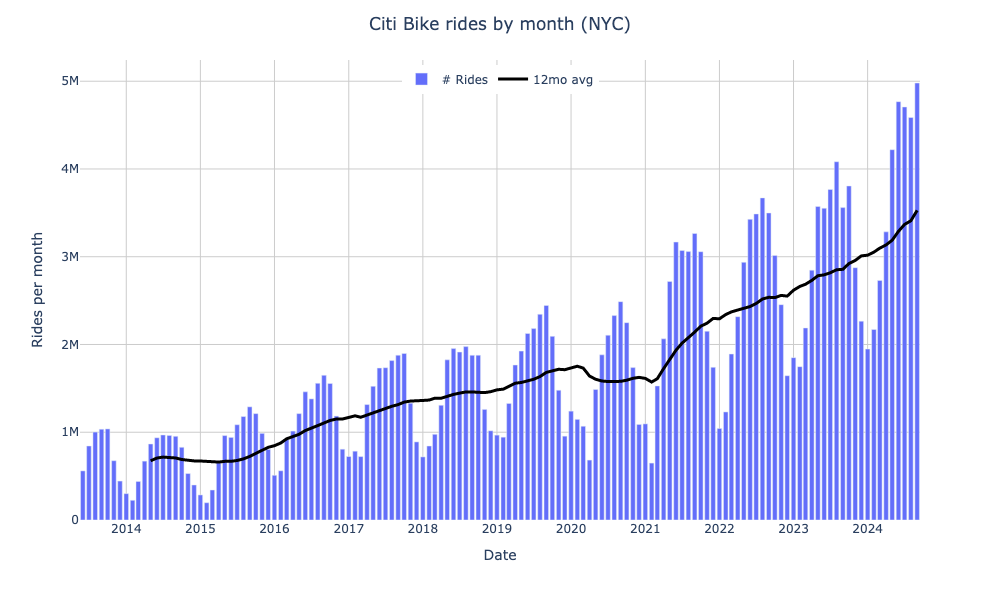

In [10]:
W = 1000
H = 600
plot_title_suffix = "" if regions == all_regions else f" ({', '.join(regions)})"
fig = px.bar(
    rides.rename('# Rides'),
    labels={
        'variable': '',
        'value': 'Rides per month',
    },
).update_layout(
    width=W,
    height=H,
    plot_bgcolor='white',
    xaxis=dict(
        dtick='M12',
    ),
    hovermode='x',
    title=dict(
        x=0.5,
        text=f"Citi Bike rides by month{plot_title_suffix}",
    ),
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="center",
        x=0.5,
        orientation="h",
    ),
).update_xaxes(
    gridcolor='#ccc',
    hoverformat=None,
).update_yaxes(
    gridcolor='#ccc',
)
fig.add_trace(
    go.Scatter(
        x=agg_12mo.index,
        y=agg_12mo,
        name='12mo avg',
        line=dict(
            color='black',
            width=3,
        ),
    )
).update_traces(
    hovertemplate='%{y:,}',
)
export(fig, name=f'plot{name_suffix}', id='plot')

In [11]:
MD("Average, annualized change in ridership, over various timeframes:", id="rates")

Average, annualized change in ridership, over various timeframes:

In [12]:
last = agg_12mo.iloc[-1]
months_ago = list(range(12, len(agg_12mo), 12))
n = len(agg_12mo)
if n % 12 != 1:
    months_ago += [n - 1]

change_stats = []
for ma in months_ago:
    rate = (last / agg_12mo.iloc[-1 - ma])**(12/ma) - 1
    avg = agg_12mo.iloc[-1 - ma]
    ya = ma // 12
    ms = ma % 12
    ago_str = f"{ya} year{'' if ya == 1 else 's'}"
    if ms:
        ago_str += f", {ms} months"
    change_stats.append({
        'Duration': ago_str,
        'Start': int(agg_12mo.iloc[-1 - ma]),
        'End': int(last),
        'Avg annual change': (last / agg_12mo.iloc[-1 - ma])**(12/ma) - 1,
        'Total change': last / avg,
    })
    # print(f"Average annual change over {ago_str:5}: {rate:>5.1%} ({int(avg):9,} → {int(last):,}, {last / avg:.2f}x total)")
change_stats = DF(change_stats).set_index('Duration')
export(
    change_stats,
    name=f"rates{name_suffix}",
    fmts={
        'Avg annual change': '.1%',
        'Total change': ',.2f',
    },
    per_page=20,
)

Saved parquet to .ire/rates-nyc.parquet
